In [58]:
from commons.load_data import load_data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 
# 

Paper: [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)

There are like a million ways to explain variational autoencoders that are needlessly complicated. Simply look at the loss function to see what is going on:

There is the constuction loss: how far from the input the generated image is 

Then there is the KL divergence loss which is a bit more complicated.
<ol>
    <li> mu and log_var are generated in the encoder, they are then compared to a smaple from a normal distrobution. 
    <li> Basically mu and log_var are penalized if they do not produce a normal distrobution with mean = 0 and std = 1.0
    <li> this "regularizes" the latent space to a normal distrobution

In [ ]:
INPUT_DIMS = (28, 28)

In [59]:
class VAE(torch.nn.Module):
    def __init__(self, latent_dims = 16) -> None:
        super(VAE, self).__init__()

        # encoder
        self.encoder_conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, (3, 3), stride = 2, padding = 1),
            torch.nn.Conv2d(32, 64, (3, 3), stride = 2, padding = 1)
        ])

        self.encoder_linear = torch.nn.Linear(7 * 7 * 64, 32)
        self.linear_mu = torch.nn.Linear(32, latent_dims)
        self.linear_log_var = torch.nn.Linear(32, latent_dims)

        # decoder
        self.decoder_linear = torch.nn.Linear(latent_dims, 7 * 7 * 64)

        self.decoder_transconv_layers = torch.nn.ModuleList([
            torch.nn.ConvTranspose2d(64, 32, 3, stride = 2, output_padding = 1, padding = 1),
            torch.nn.ConvTranspose2d(32, 32, 3, stride = 2, output_padding = 1, padding = 1), 
            torch.nn.ConvTranspose2d(32, 1, 3, stride = 1, padding = 1), 
        ])

    def encoder(self, input):
        x = self.encoder_conv_layers[0](input)
        x = F.leaky_relu(x)

        for layer in self.encoder_conv_layers[1:]:
            x = layer(x)
            x = F.leaky_relu(x)

        x = torch.flatten(x, start_dim = 1)

        x = self.encoder_linear(x)
        x = F.leaky_relu(x)

        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)

        epsilon = torch.randn_like(mu)

        sample = mu + torch.exp(log_var / 2) * epsilon
        return sample, mu, log_var

    def decoder(self, latent_space):
        x = self.decoder_linear(latent_space)
        x = F.leaky_relu(x)
        
        x = torch.reshape(x, (-1, 64, 7, 7))

        for layer in self.decoder_transconv_layers[:-1]:
            x = layer(x)
            x = F.leaky_relu(x)

        x = self.decoder_transconv_layers[-1](x)
        output = torch.sigmoid(x)
        
        return output

    def forward(self, input):
        latent_space, mu, log_var = self.encoder(input)
        output = self.decoder(latent_space)
        
        return output, mu, log_var

In [60]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_data, test_data = load_data() # load in data

epochs = 30
batch_size = 64

dkl_weight = 3e-3

latent_dims = 2

weight_decay  = 1e-5
lr_init = 1e-4

train = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [61]:
def loss_fn(output, input, mu, log_var):
    recon_loss = F.binary_cross_entropy(output, input)
    dkl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu ** 2 - log_var.exp(), axis = 1))

    loss = dkl_loss * dkl_weight + recon_loss
    return loss, recon_loss, dkl_loss

model = VAE(latent_dims = latent_dims)

opt = torch.optim.Adam(
    model.parameters(), 
    lr = lr_init, 
    weight_decay = weight_decay
    ) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = .2, patience = 1, verbose = True, cooldown = 5)

model.to(device)

VAE(
  (encoder_conv_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (encoder_linear): Linear(in_features=3136, out_features=32, bias=True)
  (linear_mu): Linear(in_features=32, out_features=2, bias=True)
  (linear_log_var): Linear(in_features=32, out_features=2, bias=True)
  (decoder_linear): Linear(in_features=2, out_features=3136, bias=True)
  (decoder_transconv_layers): ModuleList(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [62]:
print(f'Training Started 0/{epochs} epochs')
for epoch in range(epochs):
    train_loss = 0 # init train loss to 0
    train_recon_loss = 0
    train_dkl_loss = 0

    for imgs, _ in tqdm(train, mininterval= 0.5):
        opt.zero_grad()

        imgs = imgs.to(device)
        
        outputs, mu, log_var = model(imgs)
        loss, recon_loss, dkl_loss = loss_fn(outputs, imgs, mu, log_var)
        
        loss.backward()
        opt.step()

        train_loss += loss.item() 
        train_recon_loss += recon_loss.item()
        train_dkl_loss += dkl_loss.item()

    test_loss = 0 
    with torch.no_grad():
        for imgs, _ in test:
            imgs = imgs.to(device)
            outputs, mu, log_var = model(imgs)
            loss, recon_loss, dkl_loss = loss_fn(outputs, imgs, mu, log_var)
            test_loss += loss.item() 
            
    train_loss /= len(train)
    train_dkl_loss /= len(train)
    train_recon_loss /= len(train)

    test_loss /= len(test)
    

    print(f"Epoch: {epoch + 1}/{epochs} complete\tTrain loss: {train_loss:.5f} Dkl loss: {train_dkl_loss:.5f} Recon loss: {train_recon_loss:.5f}\t Test loss: {test_loss:.5f}")

    scheduler.step(test_loss)

Training Started 0/30 epochs


100%|██████████| 938/938 [00:44<00:00, 20.94it/s]


Epoch: 1/30 complete	Train loss: 0.31184 Dkl loss: 3.58194 Recon loss: 0.30110	 Test loss: 0.25014


100%|██████████| 938/938 [00:45<00:00, 20.61it/s]


Epoch: 2/30 complete	Train loss: 0.23976 Dkl loss: 4.10579 Recon loss: 0.22745	 Test loss: 0.23507


100%|██████████| 938/938 [00:45<00:00, 20.81it/s]


Epoch: 3/30 complete	Train loss: 0.23037 Dkl loss: 4.12861 Recon loss: 0.21799	 Test loss: 0.22888


100%|██████████| 938/938 [00:43<00:00, 21.43it/s]


Epoch: 4/30 complete	Train loss: 0.22518 Dkl loss: 4.15570 Recon loss: 0.21271	 Test loss: 0.22499


100%|██████████| 938/938 [00:43<00:00, 21.44it/s]


Epoch: 5/30 complete	Train loss: 0.22174 Dkl loss: 4.17316 Recon loss: 0.20922	 Test loss: 0.22249


100%|██████████| 938/938 [00:49<00:00, 19.04it/s]


Epoch: 6/30 complete	Train loss: 0.21937 Dkl loss: 4.21189 Recon loss: 0.20673	 Test loss: 0.22032


100%|██████████| 938/938 [00:58<00:00, 16.12it/s]


Epoch: 7/30 complete	Train loss: 0.21745 Dkl loss: 4.25041 Recon loss: 0.20469	 Test loss: 0.21826


100%|██████████| 938/938 [01:01<00:00, 15.37it/s]


Epoch: 8/30 complete	Train loss: 0.21585 Dkl loss: 4.28393 Recon loss: 0.20300	 Test loss: 0.21633


100%|██████████| 938/938 [01:02<00:00, 15.06it/s]


Epoch: 9/30 complete	Train loss: 0.21447 Dkl loss: 4.33889 Recon loss: 0.20145	 Test loss: 0.21528


100%|██████████| 938/938 [01:09<00:00, 13.52it/s]


Epoch: 10/30 complete	Train loss: 0.21313 Dkl loss: 4.38965 Recon loss: 0.19996	 Test loss: 0.21433


100%|██████████| 938/938 [01:06<00:00, 14.07it/s]


Epoch: 11/30 complete	Train loss: 0.21197 Dkl loss: 4.42935 Recon loss: 0.19868	 Test loss: 0.21310


100%|██████████| 938/938 [01:08<00:00, 13.60it/s]


Epoch: 12/30 complete	Train loss: 0.21099 Dkl loss: 4.47430 Recon loss: 0.19757	 Test loss: 0.21261


100%|██████████| 938/938 [01:06<00:00, 14.01it/s]


Epoch: 13/30 complete	Train loss: 0.21019 Dkl loss: 4.52544 Recon loss: 0.19662	 Test loss: 0.21141


100%|██████████| 938/938 [01:04<00:00, 14.56it/s]


Epoch: 14/30 complete	Train loss: 0.20944 Dkl loss: 4.54529 Recon loss: 0.19580	 Test loss: 0.21077


100%|██████████| 938/938 [01:01<00:00, 15.33it/s]


Epoch: 15/30 complete	Train loss: 0.20876 Dkl loss: 4.57073 Recon loss: 0.19504	 Test loss: 0.21031


100%|██████████| 938/938 [01:06<00:00, 14.02it/s]


Epoch: 16/30 complete	Train loss: 0.20814 Dkl loss: 4.59065 Recon loss: 0.19436	 Test loss: 0.20947


100%|██████████| 938/938 [01:04<00:00, 14.44it/s]


Epoch: 17/30 complete	Train loss: 0.20764 Dkl loss: 4.62759 Recon loss: 0.19376	 Test loss: 0.20962


100%|██████████| 938/938 [01:04<00:00, 14.47it/s]


Epoch: 18/30 complete	Train loss: 0.20717 Dkl loss: 4.65810 Recon loss: 0.19319	 Test loss: 0.20866


100%|██████████| 938/938 [01:01<00:00, 15.18it/s]


Epoch: 19/30 complete	Train loss: 0.20662 Dkl loss: 4.65929 Recon loss: 0.19264	 Test loss: 0.20810


100%|██████████| 938/938 [01:03<00:00, 14.82it/s]


Epoch: 20/30 complete	Train loss: 0.20624 Dkl loss: 4.69030 Recon loss: 0.19217	 Test loss: 0.20783


100%|██████████| 938/938 [01:03<00:00, 14.83it/s]


Epoch: 21/30 complete	Train loss: 0.20581 Dkl loss: 4.71296 Recon loss: 0.19167	 Test loss: 0.20805


100%|██████████| 938/938 [01:00<00:00, 15.43it/s]


Epoch: 22/30 complete	Train loss: 0.20543 Dkl loss: 4.72643 Recon loss: 0.19125	 Test loss: 0.20746


100%|██████████| 938/938 [01:01<00:00, 15.36it/s]


Epoch: 23/30 complete	Train loss: 0.20501 Dkl loss: 4.73644 Recon loss: 0.19080	 Test loss: 0.20760


100%|██████████| 938/938 [01:05<00:00, 14.39it/s]


Epoch: 24/30 complete	Train loss: 0.20473 Dkl loss: 4.75533 Recon loss: 0.19047	 Test loss: 0.20660


100%|██████████| 938/938 [01:01<00:00, 15.23it/s]


Epoch: 25/30 complete	Train loss: 0.20442 Dkl loss: 4.77446 Recon loss: 0.19010	 Test loss: 0.20706


100%|██████████| 938/938 [00:59<00:00, 15.84it/s]


Epoch: 26/30 complete	Train loss: 0.20416 Dkl loss: 4.79917 Recon loss: 0.18977	 Test loss: 0.20629


100%|██████████| 938/938 [00:59<00:00, 15.80it/s]


Epoch: 27/30 complete	Train loss: 0.20387 Dkl loss: 4.80234 Recon loss: 0.18946	 Test loss: 0.20628


100%|██████████| 938/938 [01:00<00:00, 15.56it/s]


Epoch: 28/30 complete	Train loss: 0.20361 Dkl loss: 4.81491 Recon loss: 0.18916	 Test loss: 0.20548


100%|██████████| 938/938 [01:00<00:00, 15.61it/s]


Epoch: 29/30 complete	Train loss: 0.20336 Dkl loss: 4.82686 Recon loss: 0.18888	 Test loss: 0.20495


100%|██████████| 938/938 [00:57<00:00, 16.42it/s]


Epoch: 30/30 complete	Train loss: 0.20314 Dkl loss: 4.84880 Recon loss: 0.18859	 Test loss: 0.20444


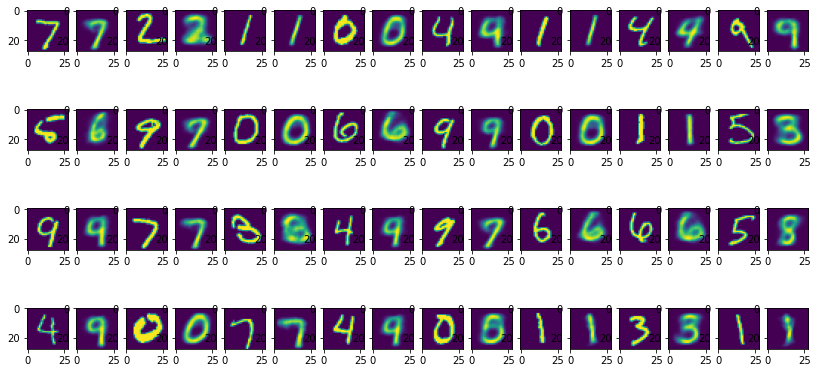

In [63]:
images, _ = iter(test).next()
_, ax = plt.subplots(4, 16, figsize = (14, 7))
with torch.no_grad():
    outputs, _, _ = model(images)

ax_flat = ax.flatten()
for i in range(0, len(ax_flat), 2):
    ax_flat[i+1].imshow(outputs[i//2][0].numpy())
    ax_flat[i].imshow(images[i//2][0].numpy())

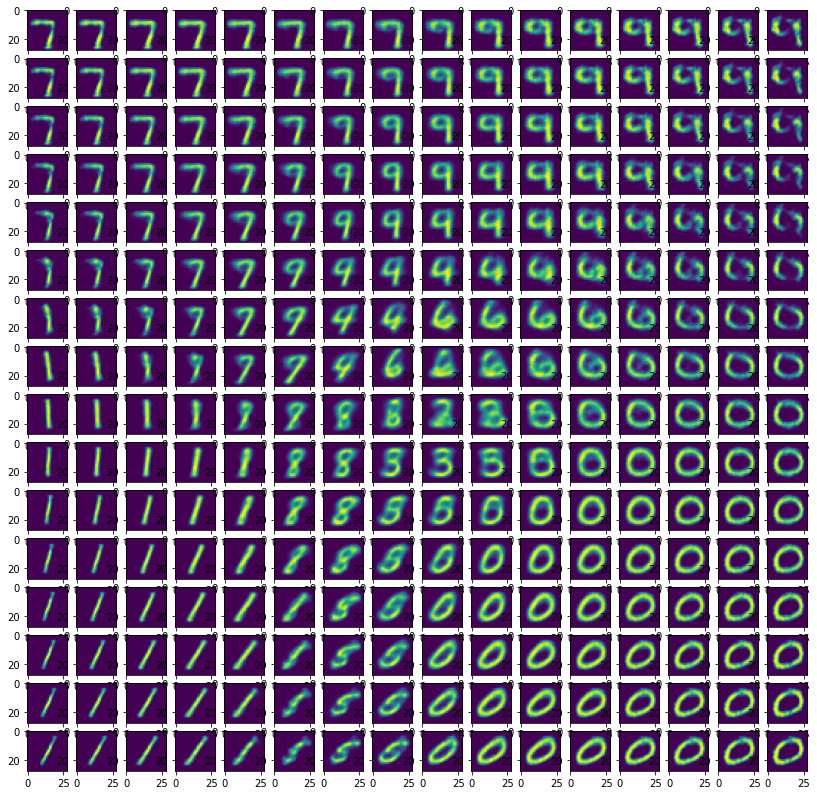

In [64]:
import numpy as np
grid_size = 16

x, y = [torch.linspace(-3, 3, grid_size)] * 2
latent_grid = torch.zeros((grid_size**2, 2))

index = 0
for i in x:
    for j in y:
        latent_grid[index, 0] = i
        latent_grid[index, 1] = j
        index += 1

_, ax = plt.subplots(grid_size, grid_size, figsize = (14, 14))
with torch.no_grad():
    outputs = model.decoder(latent_grid)

ax_flat = ax.flatten()
for i in range(len(ax_flat)):
    ax_flat[i].imshow(outputs[i][0].numpy())


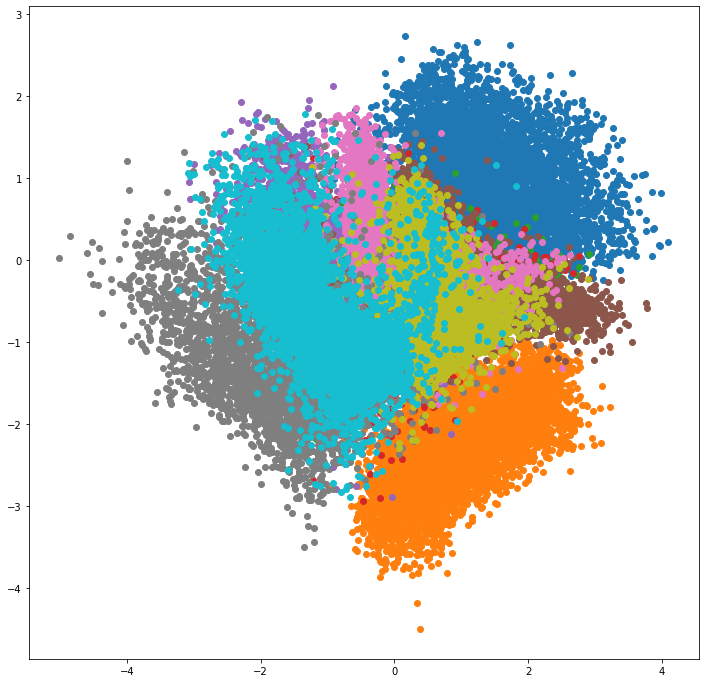

In [68]:
x, y = {}, {}
for i in range(10):
    x[f'tensor({i})'] = []
    y[f'tensor({i})'] = []

with torch.no_grad():
    for imgs, labels in test:
        imgs = imgs.to(device)
        outputs, _, _ = model.encoder(imgs)
        for output, label in zip(outputs, labels):
            x[str(label)].append(output[0])
            y[str(label)].append(output[1])

_, ax = plt.subplots(1, 1, figsize = (12, 12))
            
for key in x:
    ax.scatter(x[key], y[key])

In [66]:
str(int(torch.Tensor([3])))

'3'